In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# ResNet

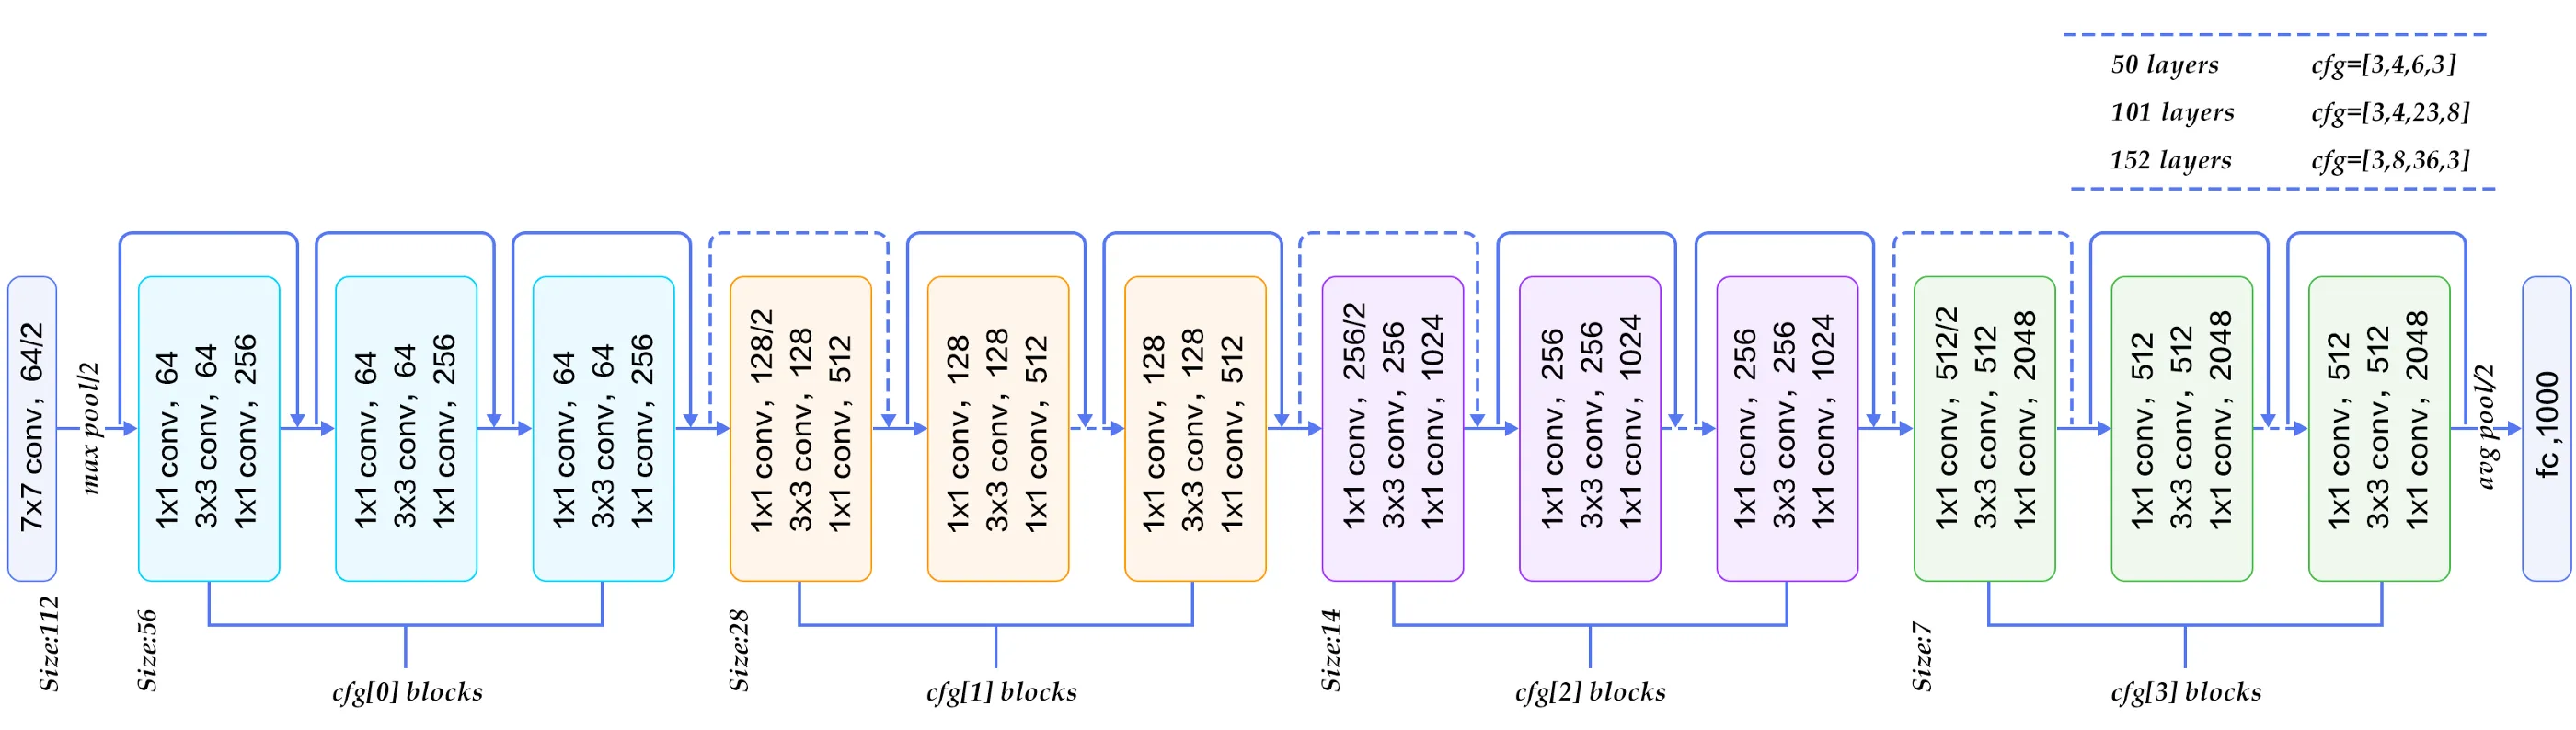

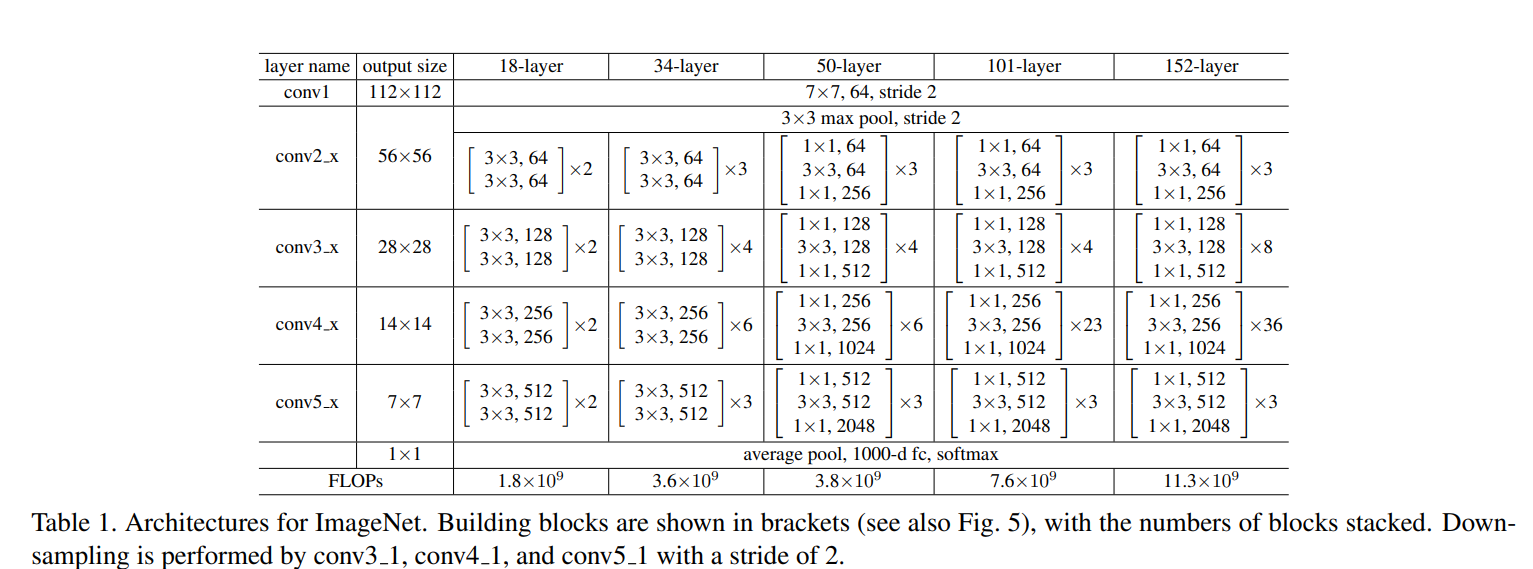

In [2]:
class BottleNeck(nn.Module):
    def __init__(self, in_channels, mid_channels, out_channels, downsample):
        super(BottleNeck, self).__init__()
        
        stride = 2 if downsample else 1 # H(x) = F(x) + x // F(x)와 x의 출력크기를 맞춰야하기 때문
        
        self.main_path = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=1, stride=stride, padding=0),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(),
            
            nn.Conv2d(mid_channels, mid_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(),
            
            nn.Conv2d(mid_channels, out_channels, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(out_channels),
        )
        
        self.shortcut = nn.Sequential()
        if downsample or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )
            
    def forward(self, x):
        out = self.main_path(x)
        out += self.shortcut(x)
        out = nn.ReLU()(out)
        
        return out
    
    
class ResNet50(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet50, self).__init__()
        
        self.conv1 = nn.Sequential(
            # nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2), # IMAGENET
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1), # CIFAR10
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(3, 2, 1),
        )
        
        self.conv2_x = nn.Sequential(
            BottleNeck(64, 64, 256, False),
            BottleNeck(256, 64, 256, False),
            BottleNeck(256, 64, 256, True),
        )
        
        self.conv3_x = nn.Sequential(
            BottleNeck(256, 128, 512, False),
            BottleNeck(512, 128, 512, False),
            BottleNeck(512, 128, 512, False),
            BottleNeck(512, 128, 512, True),
        )
        
        self.conv4_x = nn.Sequential(
            BottleNeck(512, 256, 1024, False),
            BottleNeck(1024, 256, 1024, False),
            BottleNeck(1024, 256, 1024, False),
            BottleNeck(1024, 256, 1024, False),
            BottleNeck(1024, 256, 1024, False),
            BottleNeck(1024, 256, 1024, True),
        )
        
        self.conv5_x = nn.Sequential(
            BottleNeck(1024, 512, 2048, False),
            BottleNeck(2048, 512, 2048, False),
            BottleNeck(2048, 512, 2048, False),
        )
        
        self.avgpool = nn.AvgPool2d((1, 1), stride=1)
        self.fc_layer = nn.Linear(8192, num_classes)
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2_x(out)
        out = self.conv3_x(out)
        out = self.conv4_x(out)
        out = self.conv5_x(out)
        out = self.avgpool(out)
        out = out.view(out.size()[0], -1)
        out = self.fc_layer(out)
        
        return out

# Data

In [3]:
batch_size = 512
lr = 0.0002
num_epochs = 50

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

cifar10_train = datasets.CIFAR10(root="./CIFAR10/", train=True, transform=transform, target_transform=None, download=False)
cifar10_test = datasets.CIFAR10(root="./CIFAR10/", train=False, transform=transform, target_transform=None, download=False)

train_loader = DataLoader(cifar10_train, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(cifar10_test, batch_size=batch_size, shuffle=False, num_workers=4)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = ResNet50().to(device)
for i in model.named_children():
    print(i)

cuda
('conv1', Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
))
('conv2_x', Sequential(
  (0): BottleNeck(
    (main_path): Sequential(
      (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
      (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (shortcut): Sequential(
      (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05

# Train

In [5]:
optimizer = optim.Adam(model.parameters(),lr=lr)
criterion = nn.CrossEntropyLoss()

losses_for_epoch = []
model.train()
for epoch in range(num_epochs):
    losses = []
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
    
    avg_loss = sum(losses) / len(losses)
    losses_for_epoch.append(avg_loss)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{num_epochs}, Avg Loss: {avg_loss:.6f}")

Epoch 0/50, Avg Loss: 2.161391
Epoch 10/50, Avg Loss: 0.207072
Epoch 20/50, Avg Loss: 0.237739
Epoch 30/50, Avg Loss: 0.045231
Epoch 40/50, Avg Loss: 0.037864


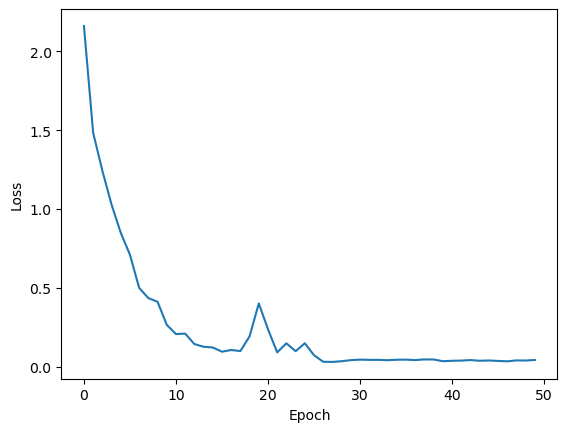

In [9]:
import matplotlib.pyplot as plt
plt.plot(losses_for_epoch)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Test

In [10]:
total = 0
correct = 0

model.eval()
with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        outputs = torch.argmax(outputs, dim=1)
    
        total += len(labels)
        correct += (labels == outputs).sum()

print(f"Accuracy: {(correct/total)*100}%")

Accuracy: 67.78999328613281%
